## a) Set de 10 valores dados por el catedrático
Los siguientes son los 10 valores base para el ejercicio:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Semilla para reproducibilidad
np.random.seed(42)

# (a) Set de 10 valores
data = np.array([8, 8, 5, 9, 8, 10, 8, 7, 10, 1], dtype=float)

print("Valores (a):", data.tolist())
print("Media original:", data.mean())


Valores (a): [8.0, 8.0, 5.0, 9.0, 8.0, 10.0, 8.0, 7.0, 10.0, 1.0]
Media original: 7.4


## b) Set de 10 valores de probabilidad dados por el catedrático
Las probabilidades asociadas (para usar con Transformada Inversa) son:

In [5]:
# (b) Probabilidades (puede haber pequeño redondeo; se normaliza)
p = np.array([0.4, 0.17, 0.01, 0.04, 0.08, 0.01, 0.04, 0.02, 0.01, 0.21999999999999986], dtype=float)
p = p / p.sum()  # normalizar por si hay mínimos errores de redondeo

print("Probabilidades (b):", p.tolist())
print("Suma probabilidades:", p.sum())


Probabilidades (b): [0.4, 0.17, 0.01, 0.04, 0.08, 0.01, 0.04, 0.02, 0.01, 0.21999999999999986]
Suma probabilidades: 1.0


## c) Explicación del método de Bootstrapping
Bootstrapping es un método de remuestreo con reemplazo que genera muchas réplicas de la muestra original para aproximar la distribución de un estadístico (por ejemplo, la media). Cada réplica se obtiene seleccionando observaciones al azar (con reemplazo) de la muestra original usando un generador de aleatoriedad. Con estas réplicas se calculan medias, desviaciones y cuantiles para estimar incertidumbre (error estándar, intervalos de confianza) sin requerir supuestos fuertes de normalidad. En este examen, además, las selecciones se realizan mediante Transformada Inversa usando las probabilidades proporcionadas por el catedrático.

# d) Código de método de Bootstrapping
 d.i) Código de método de Transformada Inversa (discreta)



In [7]:
# Utilidades para transformada inversa discreta
cdf = np.cumsum(p)

def inv_transform_discrete(cdf, u):
    """
    Dada una CDF discreta (numpy array creciente) y u ~ U(0,1),
    retorna el índice i tal que CDF[i-1] < u <= CDF[i].
    """
    return int(np.searchsorted(cdf, u, side='left'))

# Centrar los datos a media 0 (opcional, útil para verificar sesgo en las medias bootstrap)
media_original = data.mean()
data_offset = data - media_original

B = 10_000      # réplicas bootstrap
N = len(data)   # tamaño de muestra por réplica

bootstrap_means = np.empty(B, dtype=float)

# Usamos U(0,1) de NumPy para este bloque
U = np.random.rand(B * N)
pos = 0
for b in range(B):
    idxs = [inv_transform_discrete(cdf, U[pos + i]) for i in range(N)]
    pos += N
    sample = data_offset[idxs]    # muestra centrada
    bootstrap_means[b] = sample.mean()

print("Resumen bootstrap (medias de datos centrados):")
print("  Media de las medias (≈ 0 por centrado):", bootstrap_means.mean())
print("  Desviación estándar (std) de las medias:", bootstrap_means.std(ddof=1))



Resumen bootstrap (medias de datos centrados):
  Media de las medias (≈ 0 por centrado): -0.9043900000000001
  Desviación estándar (std) de las medias: 0.9332367443377366


## d.ii) Histograma de resultados (medias bootstrap)

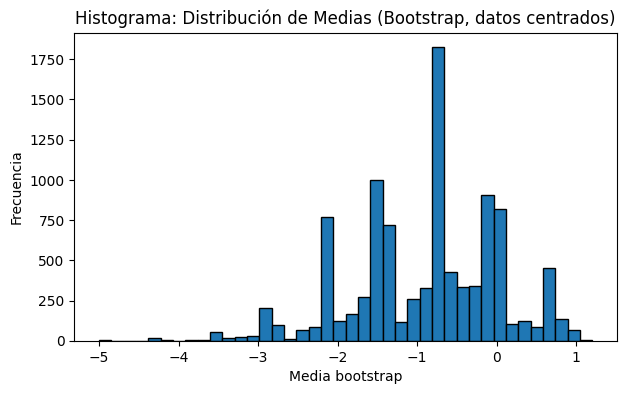

In [8]:
plt.figure(figsize=(7,4))
plt.hist(bootstrap_means, bins=40, edgecolor='black')
plt.title("Histograma: Distribución de Medias (Bootstrap, datos centrados)")
plt.xlabel("Media bootstrap")
plt.ylabel("Frecuencia")
plt.show()


## d.iii) Desviación estándar de la distribución de medias

In [9]:
std_bootstrap_means = bootstrap_means.std(ddof=1)
print("Desviación estándar de la distribución de medias (d.iii):", std_bootstrap_means)


Desviación estándar de la distribución de medias (d.iii): 0.9332367443377366


##e) Cálculo de probabilidades para cada rango de la distribución de medias
Se divide la distribución de medias en 5 rangos uniformes (mismo ancho) y se estima la probabilidad empírica en cada rango.xx

In [10]:
bins = 5
min_m, max_m = bootstrap_means.min(), bootstrap_means.max()
edges = np.linspace(min_m, max_m, bins + 1)   # 6 bordes => 5 rangos
counts, _ = np.histogram(bootstrap_means, bins=edges)
prob_bins = counts / counts.sum()
bin_centers = 0.5 * (edges[:-1] + edges[1:])

print("Rangos y probabilidades (e):")
for i in range(bins):
    a, b_ = edges[i], edges[i+1]
    print(f"  Bin {i+1}: [{a:.6f}, {b_:.6f}) -> P = {prob_bins[i]:.6f}")


Rangos y probabilidades (e):
  Bin 1: [-5.000000, -3.760000) -> P = 0.003200
  Bin 2: [-3.760000, -2.520000) -> P = 0.044300
  Bin 3: [-2.520000, -1.280000) -> P = 0.320300
  Bin 4: [-1.280000, -0.040000) -> P = 0.452800
  Bin 5: [-0.040000, 1.200000) -> P = 0.179400


## f) Código de Aceptación y Rechazo

### f.i) Distribución de probabilidad simplificada y sus ecuaciones

Definimos una distribución discreta de 5 categorías (los *bins* anteriores) con **PMF** $p_i$ dada por `prob_bins`.

- **Distribución propuesta** (uniforme):  
  $q_i = \frac{1}{5}$

- **Razón de mayoración**:  
  $c = \max_i \frac{p_i}{q_i} = 5 \cdot \max_i p_i$

- **Probabilidad de aceptación** para una categoría $j$:  
  $\frac{p_j}{c \cdot q_j} = \frac{p_j}{\max_i p_i}$

*(Las ecuaciones ya están descritas; abajo el código que las implementa.)*

---

### f.ii) Ecuación del Generador Congruencial Lineal Mixto (LCG)

Usamos el LCG clásico (tipo *glibc*):

$$
X_{n+1} = (aX_n + c) \mod m
$$

**Parámetros**:  
- $a = 1103515245$  
- $c = 12345$  
- $m = 2^{31}$

**Valor uniforme**:  
$U_n = \frac{X_n}{m}$

---

### f.iii) Parámetro de rechazo y aceptación

- **Constante $c$**:  
  $$
  c = \max_i \frac{p_i}{q_i} = 5 \cdot \max_i p_i
  $$

- **Umbral de aceptación** para la categoría $i$:  
  $$
  \text{umbral}_i = \frac{p_i}{\max_i p_i}
  $$

In [11]:
# --- LCG (Generador congruencial lineal mixto)
class LCG:
    """
    X_{n+1} = (a*X_n + c) mod m
    a = 1103515245, c = 12345, m = 2^31
    """
    def __init__(self, seed=987654321, a=1103515245, c=12345, m=2**31):
        self.state = seed % m
        self.a = a
        self.c = c
        self.m = m

    def rand(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def rand_uniform(self):
        return self.rand() / self.m

# Propuesta uniforme sobre 5 categorías
q = np.full(bins, 1.0/bins)
maxp = prob_bins.max()
c_AR = (prob_bins / q).max()   # = 5 * max(prob_bins)

def propuesta_indice(lcg):
    # 5 intervalos iguales en (0,1) -> índices 0..4
    u = lcg.rand_uniform()
    return min(int(u * bins), bins-1)

def aceptar(i, lcg):
    # Umbral por categoría i: p_i / maxp
    u = lcg.rand_uniform()
    return u <= (prob_bins[i] / maxp if maxp > 0 else 0.0)

# Generar M muestras aceptadas
M = 10_000
lcg = LCG(seed=987654321)
accepted_indices = []
while len(accepted_indices) < M:
    j = propuesta_indice(lcg)
    if aceptar(j, lcg):
        accepted_indices.append(j)

accepted_indices = np.array(accepted_indices, dtype=int)
samples_simplified = bin_centers[accepted_indices]

print(f"Constante c (f.iii): {c_AR:.6f}  (5 * max(prob_bins) = {5*maxp:.6f})")
print(f"Muestras aceptadas (M): {len(accepted_indices)}")


Constante c (f.iii): 2.264000  (5 * max(prob_bins) = 2.264000)
Muestras aceptadas (M): 10000


## f.iv) Graficar PMF estimada y CDF estimada de la distribución simplificada


PMF estimada (5 categorías):
  Cat 1 (centro -4.380000): PMF ~ 0.004100
  Cat 2 (centro -3.140000): PMF ~ 0.046500
  Cat 3 (centro -1.900000): PMF ~ 0.318100
  Cat 4 (centro -0.660000): PMF ~ 0.449400
  Cat 5 (centro 0.580000): PMF ~ 0.181900

CDF estimada (acumulada):
  <= Cat 1: CDF ~ 0.004100
  <= Cat 2: CDF ~ 0.050600
  <= Cat 3: CDF ~ 0.368700
  <= Cat 4: CDF ~ 0.818100
  <= Cat 5: CDF ~ 1.000000


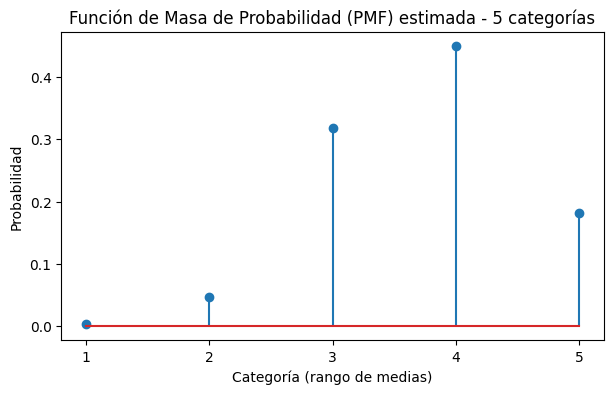

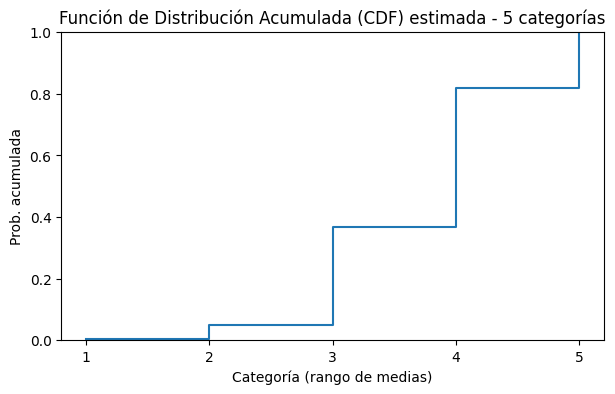

In [12]:
# PMF y CDF estimadas a partir de las muestras aceptadas
counts_simplified = np.bincount(accepted_indices, minlength=bins)
pmf_est = counts_simplified / counts_simplified.sum()
cdf_est = np.cumsum(pmf_est)

print("\nPMF estimada (5 categorías):")
for i in range(bins):
    print(f"  Cat {i+1} (centro {bin_centers[i]:.6f}): PMF ~ {pmf_est[i]:.6f}")

print("\nCDF estimada (acumulada):")
for i in range(bins):
    print(f"  <= Cat {i+1}: CDF ~ {cdf_est[i]:.6f}")

# Gráficas
plt.figure(figsize=(7,4))
plt.stem(range(1, bins+1), pmf_est)
plt.title("Función de Masa de Probabilidad (PMF) estimada - 5 categorías")
plt.xlabel("Categoría (rango de medias)")
plt.ylabel("Probabilidad")
plt.xticks(range(1, bins+1))
plt.show()

plt.figure(figsize=(7,4))
plt.step(range(1, bins+1), cdf_est, where='post')
plt.title("Función de Distribución Acumulada (CDF) estimada - 5 categorías")
plt.xlabel("Categoría (rango de medias)")
plt.ylabel("Prob. acumulada")
plt.xticks(range(1, bins+1))
plt.ylim(0,1)
plt.show()


## g) Aplicación
En una app, esta metodología sirve para tomar decisiones con incertidumbre medida. Con bootstrapping estimas intervalos de confianza de métricas clave (tiempo de carga, conversión, retención) y haces A/B testing robusto incluso con pocas muestras. Al discretizar resultados y usar aceptación–rechazo (con un LCG para reproducibilidad en el dispositivo), puedes simular usuarios/sesiones sintéticas según las probabilidades observadas y probar cambios offline (UX, precios, recomendaciones, alertas). Así despliegas un feature solo si la probabilidad de empeorar la métrica es baja (p. ej., <5%), priorizas riesgos y optimizas la app con evidencia.

